In [34]:
import tensorflow as tf 
import IPython
import functools
# %pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
assert len(tf.config.list_physical_devices('GPU')) > 0

AssertionError: 

In [5]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1) / 255.0).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1) / 255.0).astype(np.float32)
test_labels = (test_labels).astype(np.int64)


def build_fc_model():
    fc_model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(10, activation=tf.nn.softmax),
        ]
    )
    return fc_model


model = build_fc_model()
model.compile(
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
BATCH_SIZE = 64
EPOCHS = 5

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)
test_loss, test_acc =model.evaluate(test_images, test_labels)
print(test_loss,test_acc)

Epoch 1/5
938/938 [==============================] - 1s 550us/step - loss: 0.3686 - accuracy: 0.8984
Epoch 2/5
938/938 [==============================] - 1s 590us/step - loss: 0.1976 - accuracy: 0.9434
Epoch 3/5
938/938 [==============================] - 1s 542us/step - loss: 0.1489 - accuracy: 0.9575
Epoch 4/5
938/938 [==============================] - 1s 564us/step - loss: 0.1206 - accuracy: 0.9653
Epoch 5/5
313/313 [==============================] - 0s 381us/step - loss: 0.1052 - accuracy: 0.9681
0.10522395372390747 0.9681000113487244


In [10]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)  
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1789 - accuracy: 0.9458
Epoch 2/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0539 - accuracy: 0.9830
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0364 - accuracy: 0.9883
Epoch 4/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0285 - accuracy: 0.9911
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9869
Test accuracy: 0.9868999719619751


313/313 [==============================] - 0s 1ms/step


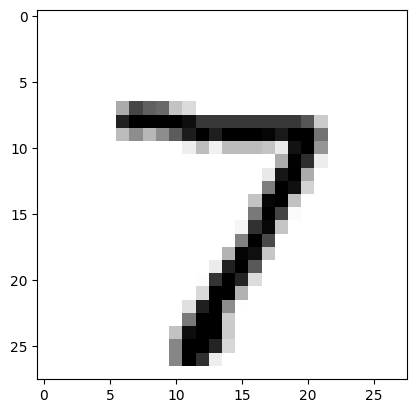

In [11]:
predictions = cnn_model.predict(test_images)
prediction =np.argmax(predictions[0]) 
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

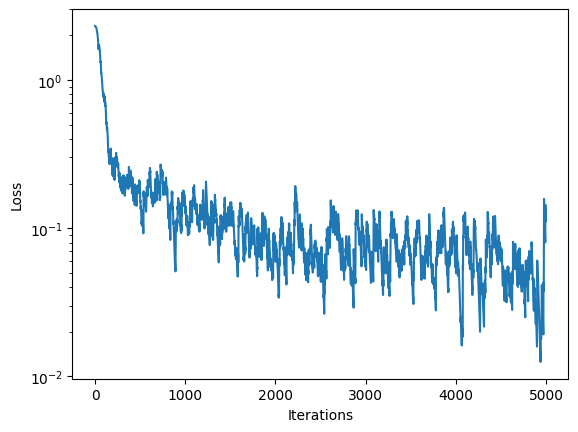

100%|██████████| 5000/5000 [00:35<00:00, 141.27it/s]


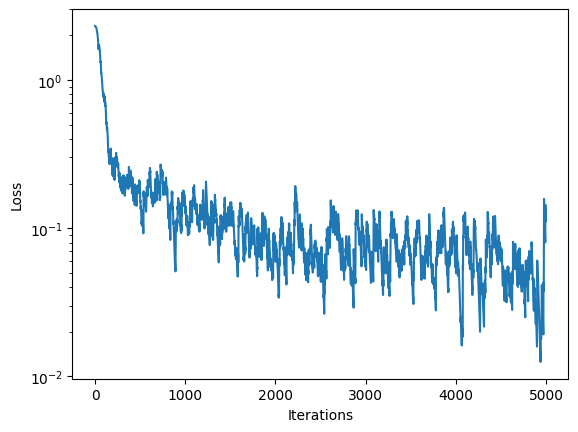

In [12]:
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(
    sec=2, xlabel="Iterations", ylabel="Loss", scale="semilogy"
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
    (images, labels) = (
        train_images[idx : idx + batch_size],
        train_labels[idx : idx + batch_size],
    )
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    with tf.GradientTape() as tape:
        logits = cnn_model(images)

        loss_value = tf.keras.backend.sparse_categorical_crossentropy(
            labels, logits
        ) 

    loss_history.append(loss_value.numpy().mean())
    plotter.plot(loss_history.get())

    grads = tape.gradient(loss_value, cnn_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))

In [17]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)  
print( cnn_model.evaluate(test_images, test_labels))

313/313 [==============================] - 0s 1ms/step - loss: 0.0527 - accuracy: 0.9825
[0.05274666100740433, 0.9825000166893005]


In [18]:
path_to_training_data = tf.keras.utils.get_file(
    "train_face.h5", "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
)
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Opening /Users/lucas/.keras/datasets/train_face.h5
Loading data into memory...


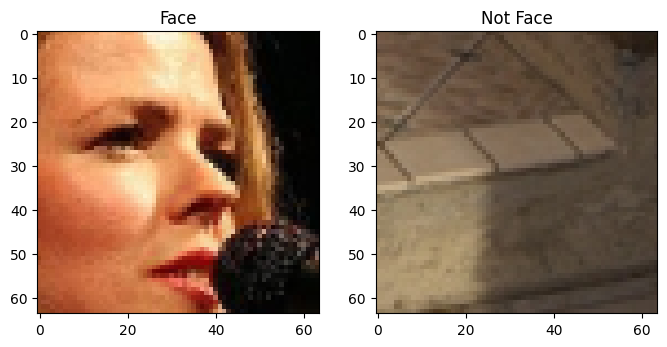

In [21]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 19 
idx_not_face = 8 

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

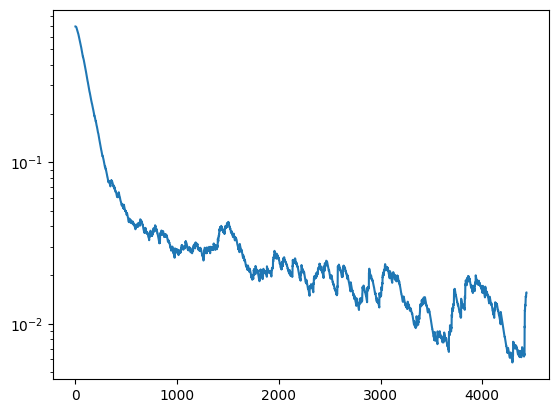

 31%|███▏      | 1080/3434 [00:20<00:44, 53.22it/s]


KeyboardInterrupt: 

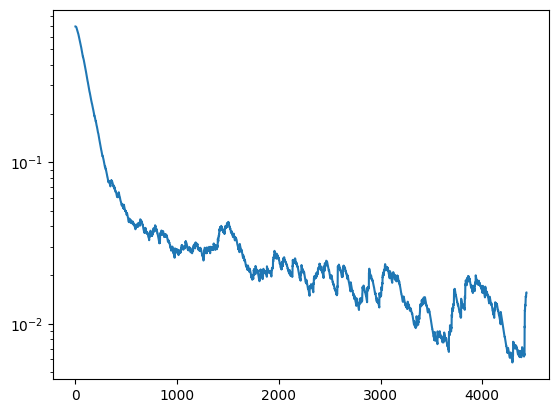

In [23]:
n_filters = 12

def make_standard_classifier(n_outputs=1):
    Conv2D = functools.partial(
        tf.keras.layers.Conv2D, padding="same", activation="relu"
    )
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation="relu")

    model = tf.keras.Sequential(
        [
            Conv2D(filters=1 * n_filters, kernel_size=5, strides=2),
            BatchNormalization(),
            Conv2D(filters=2 * n_filters, kernel_size=5, strides=2),
            BatchNormalization(),
            Conv2D(filters=4 * n_filters, kernel_size=3, strides=2),
            BatchNormalization(),
            Conv2D(filters=6 * n_filters, kernel_size=3, strides=2),
            BatchNormalization(),
            Flatten(),
            Dense(512),
            Dense(n_outputs, activation=None),
        ]
    )
    return model

standard_classifier = make_standard_classifier()

batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale="semilogy")
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()

@tf.function
def standard_train_step(x, y):
    with tf.GradientTape() as tape:
        logits = standard_classifier(x)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

    grads = tape.gradient(loss, standard_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
    return loss


for epoch in range(num_epochs):
    for idx in tqdm(range(loader.get_train_size() // batch_size)):
        x, y = loader.get_batch(batch_size)
        loss = standard_train_step(x, y)

        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

In [24]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 1s 6ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9910


Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

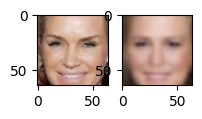

  9%|▉         | 313/3434 [00:07<01:11, 43.42it/s]


KeyboardInterrupt: 

In [26]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    latent_loss = 0.5 * tf.reduce_sum(
        tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1
    )
    reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1, 2, 3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss


def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.reduce_mean(0.5 * z_logsigma) * epsilon

    return z


def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)  # TODO
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y, logits=y_logit
    )
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

    total_loss = tf.reduce_mean(classification_loss + vae_loss * face_indicator)

    return total_loss, classification_loss, vae_loss


### Define the decoder portion of the SS-VAE ###


def make_face_decoder_network(n_filters=12):
    Conv2DTranspose = functools.partial(
        tf.keras.layers.Conv2DTranspose, padding="same", activation="relu"
    )
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation="relu")
    Reshape = tf.keras.layers.Reshape

    decoder = tf.keras.Sequential(
        [
            Dense(units=4 * 4 * 6 * n_filters),
            Reshape(target_shape=(4, 4, 6 * n_filters)),
            Conv2DTranspose(filters=4 * n_filters, kernel_size=3, strides=2),
            Conv2DTranspose(filters=2 * n_filters, kernel_size=3, strides=2),
            Conv2DTranspose(filters=1 * n_filters, kernel_size=5, strides=2),
            Conv2DTranspose(filters=3, kernel_size=5, strides=2),
        ]
    )

    return decoder


class SS_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(SS_VAE, self).__init__()
        self.latent_dim = latent_dim
        num_encoder_dims = 2 * self.latent_dim + 1

        self.encoder = make_standard_classifier(num_encoder_dims)
        self.decoder = make_face_decoder_network()

    def encode(self, x):
        encoder_output = self.encoder(x)
        y_logit = tf.expand_dims(encoder_output[:, 0], -1)
        z_mean = encoder_output[:, 1 : self.latent_dim + 1]
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]

        return y_logit, z_mean, z_logsigma

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def call(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = sampling(z_mean, z_logsigma)
        recon = self.decode(z)

        return y_logit, z_mean, z_logsigma, recon

    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit


batch_size = 32
learning_rate = 5e-4
latent_dim = 32
num_epochs = 6

ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def ss_vae_train_step(x, y):
    with tf.GradientTape() as tape:
        y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

        loss, class_loss, _ = ss_vae_loss_function(
            x, x_recon, y, y_logit, z_mean, z_logsigma
        )

    grads = tape.gradient(loss, ss_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
    return loss

all_faces = loader.get_all_train_faces()

if hasattr(tqdm, "_instances"):
    tqdm._instances.clear() 

for i in range(num_epochs):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, num_epochs))

    for j in tqdm(range(loader.get_train_size() // batch_size)):
        (x, y) = loader.get_batch(batch_size)
        loss = ss_vae_train_step(x, y)

        if j % 500 == 0:
            mdl.util.plot_sample(x, y, ss_vae)

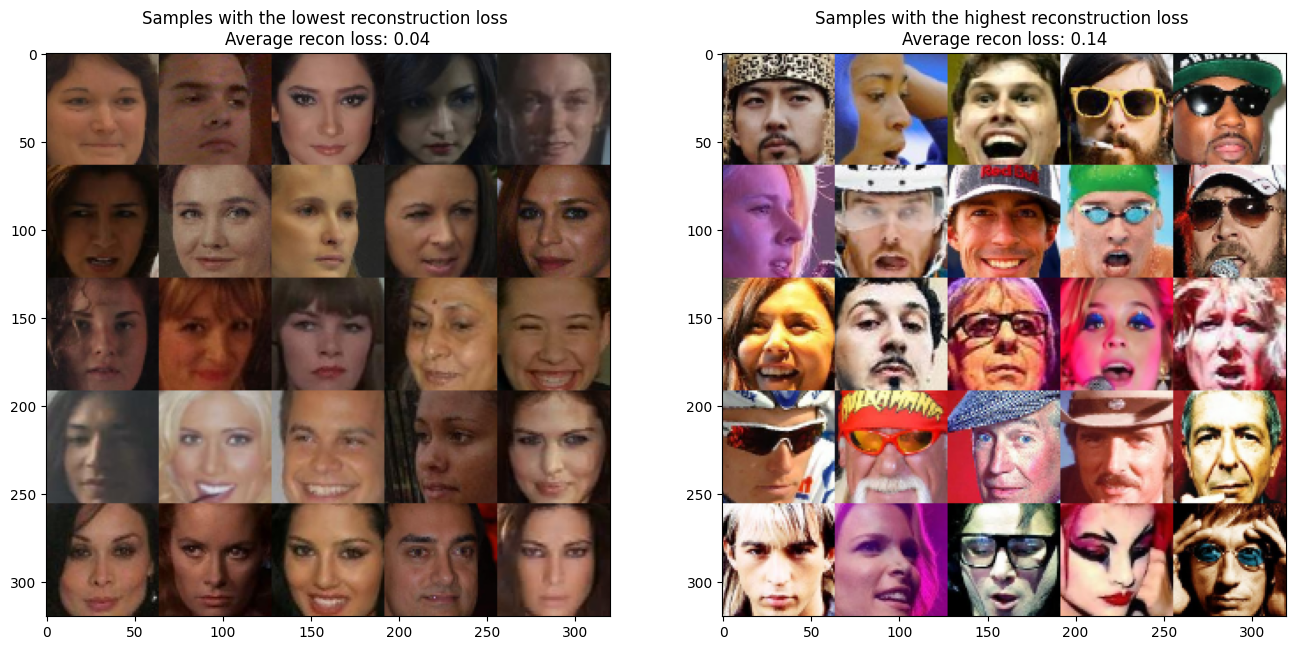

In [27]:
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");


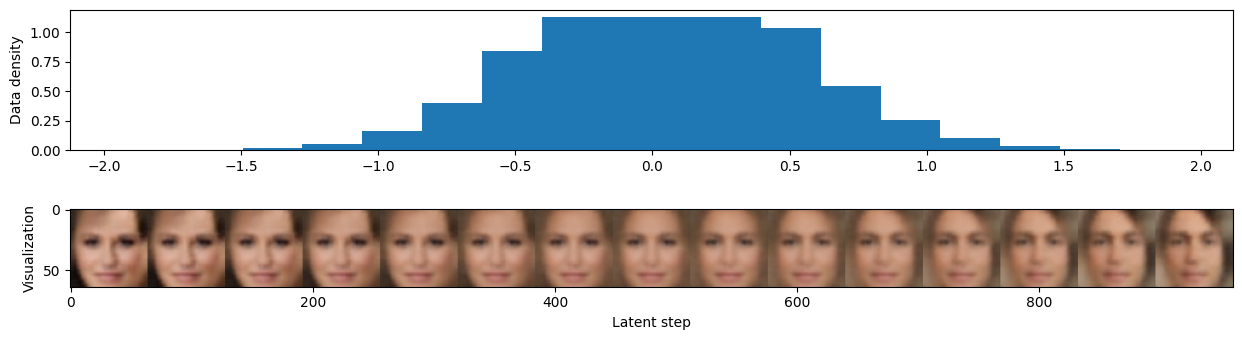

In [32]:
idx_latent = 8 
num_steps = 15

latent_samples = z_mean[:, idx_latent]

density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps: 
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step
  recons.append(ss_vae.decode(latent)[0])

ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");

Text(0, 0.5, 'Relative accuracy')

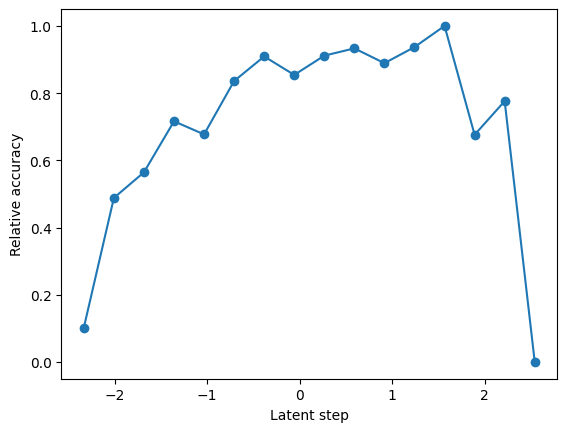

In [30]:
avg_logit_per_bin = []
for idx_latent in range(latent_dim): 
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  which_latent_bin = np.digitize(latent_samples, latent_steps)
  
  avg_logit = []
  for j in range(0, num_steps+1): 
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)
  
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")
